In [1]:
import torch
import pandas as pd
import numpy as np
from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os

In [2]:
# Clear GPU memory cache
torch.cuda.empty_cache()

# Assuming the annotations are in a text file
annotations_file = 'annotation.txt'  # Replace with your actual annotation file path
image_folder = './'  # Replace with your actual image folder path

# Read the annotations
annotations = pd.read_csv(annotations_file, sep=' ', header=None)

In [3]:
# Define the transformations: ToTensor converts image to float32, and Normalize scales the values
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),  # Converts PIL image to torch.FloatTensor and scales pixel values to [0, 1]
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Optional normalization
])

In [4]:
# Load images and gaze vectors
images = []
gaze_vectors = []
for idx, row in annotations.iterrows():
    # Format the image filename as '0001.jpg', '0002.jpg', ...
    image_filename = f'{idx + 1:04d}.jpg'
    image_path = os.path.join(image_folder, image_filename)

    # Open the image
    image = Image.open(image_path).convert('RGB')

    # Apply transformations
    image = data_transforms(image)

    images.append(image)
    gaze_vectors.append(row[-3:].values)  # Gaze vector (last three values)
    print(row[-3:].values)



[3.37297100e+01 8.55730000e-02 4.96778839e+02]
[ 29.303507  -4.314788 506.805176]
[ 47.553963  -2.858423 502.66275 ]
[ 37.173645  -7.623289 504.744324]
[ 30.091526  -7.215638 508.094513]
[ 57.762398  -6.582275 509.857971]
[ 41.543549  -8.969244 507.867218]
[ 37.766949  -7.256772 507.062195]
[ 41.053429   2.658551 503.027008]
[ 27.661318  -1.930422 512.606323]
[ 52.394478  -4.675189 510.532684]
[ 27.32032    3.097998 511.049408]
[ 42.908981   3.126679 506.1091  ]
[ 24.563528  -4.689336 515.08551 ]
[ 38.773979  -8.071581 510.506073]
[ 52.484982   0.596725 509.331848]
[ 30.278419  -3.519076 514.677795]
[ 58.127552   2.636435 511.091064]
[ 35.058273  -7.985459 513.993225]
[ 59.763691  -4.959296 516.282471]
[ 32.553005   5.571895 430.433777]
[ 19.185926  10.23373  427.754639]
[ 12.44047   15.441899 431.355713]
[ 36.850418   5.358436 436.780457]
[ 30.035086  10.158276 425.126984]
[ 32.265335  24.573025 423.992828]
[ 30.12619   14.782732 425.175079]
[ 36.504978  15.944487 425.400299]
[ 25.193

In [5]:
# Dataset definition
class GazeDataset(Dataset):
    def __init__(self, images, gaze_vectors):
        self.images = images
        self.gaze_vectors = gaze_vectors

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], torch.tensor(self.gaze_vectors[idx], dtype=torch.float32)

gaze_dataset = GazeDataset(images, gaze_vectors)

In [6]:
# Split into training and validation datasets
train_size = int(0.8 * len(gaze_dataset))
val_size = len(gaze_dataset) - train_size
train_dataset, val_dataset = random_split(gaze_dataset, [train_size, val_size])

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)  # Adjust batch size if needed
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=True)


In [7]:
# CNN model definition
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        # Dynamically calculate the input size for fully connected layers
        self.fc1 = None
        self.fc2 = nn.Linear(128, 3)  # Output layer for 3 gaze vector components

        # Initialize the fully connected layer
        self._initialize_fc1()

    def _initialize_fc1(self):
        # Create a dummy tensor with the size of the input images
        dummy_input = torch.randn(1, 3, 224, 224)  # Adjust the size as needed
        # Pass it through the convolutional layers
        x = F.relu(self.conv1(dummy_input))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)

        # Calculate the flattened size after the conv layers
        flatten_size = x.numel()  # Get the number of elements
        self.fc1 = nn.Linear(flatten_size, 128)  # Set the input size for fc1

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)

        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate model, loss function, and optimizer
model = CNNModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [8]:
# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

CNNModel(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc2): Linear(in_features=128, out_features=3, bias=True)
  (fc1): Linear(in_features=401408, out_features=128, bias=True)
)

In [9]:

# Training parameters
num_epochs = 10

# # Training and validation loop
# for epoch in range(num_epochs):
#     model.train()  # Set model to training mode
#     running_loss = 0.0

#     # Training loop
#     for images, gaze_vectors in train_loader:
#         # Move data to GPU if available
#         images = images.to(device)
#         gaze_vectors = gaze_vectors.to(device)

#         # Zero gradients from the previous step
#         optimizer.zero_grad()

#         # Forward pass: compute the output
#         outputs = model(images)

#         # Compute the loss
#         loss = criterion(outputs, gaze_vectors)

#         # Backward pass: compute gradients
#         loss.backward()

#         # Update the model parameters
#         optimizer.step()

#         # Accumulate the running loss
#         running_loss += loss.item()

#     # Calculate average loss over the epoch
#     epoch_loss = running_loss / len(train_loader)
#     print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}')

#     # Validation loop
#     model.eval()  # Set model to evaluation mode
#     val_loss = 0.0
#     with torch.no_grad():  # No need to compute gradients during validation
#         for images, gaze_vectors in val_loader:
#             images = images.to(device)
#             gaze_vectors = gaze_vectors.to(device)

#             outputs = model(images)
#             loss = criterion(outputs, gaze_vectors)
#             val_loss += loss.item()

#     # Calculate average validation loss
#     val_loss = val_loss / len(val_loader)
#     print(f'Validation Loss: {val_loss:.4f}')


In [10]:
# Initialize lists to store loss values
train_loss_history = []
val_loss_history = []

# Training and validation loop
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0

    # Training loop
    for images, gaze_vectors in train_loader:
        # Move data to GPU if available
        images = images.to(device)
        gaze_vectors = gaze_vectors.to(device)

        # Zero gradients from the previous step
        optimizer.zero_grad()

        # Forward pass: compute the output
        outputs = model(images)

        # Compute the loss
        loss = criterion(outputs, gaze_vectors)

        # Backward pass: compute gradients
        loss.backward()

        # Update the model parameters
        optimizer.step()

        # Accumulate the running loss
        running_loss += loss.item()

    # Calculate average loss over the epoch and store it
    epoch_loss = running_loss / len(train_loader)
    train_loss_history.append(epoch_loss)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {epoch_loss:.4f}')

    # Validation loop
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():  # No need to compute gradients during validation
        for images, gaze_vectors in val_loader:
            images = images.to(device)
            gaze_vectors = gaze_vectors.to(device)

            outputs = model(images)
            loss = criterion(outputs, gaze_vectors)
            val_loss += loss.item()

    # Calculate average validation loss and store it
    val_loss = val_loss / len(val_loader)
    val_loss_history.append(val_loss)
    print(f'Validation Loss: {val_loss:.4f}')


Epoch [1/10], Training Loss: 4664.5208
Validation Loss: 2399.8353
Epoch [2/10], Training Loss: 933.0313
Validation Loss: 678.3693
Epoch [3/10], Training Loss: 760.3118
Validation Loss: 660.5799
Epoch [4/10], Training Loss: 522.4505
Validation Loss: 611.6918
Epoch [5/10], Training Loss: 383.4844
Validation Loss: 621.4515
Epoch [6/10], Training Loss: 344.9722
Validation Loss: 595.9590
Epoch [7/10], Training Loss: 432.7849
Validation Loss: 766.1104
Epoch [8/10], Training Loss: 303.7466
Validation Loss: 518.8697
Epoch [9/10], Training Loss: 284.6247
Validation Loss: 565.9797
Epoch [10/10], Training Loss: 236.6405
Validation Loss: 450.5384


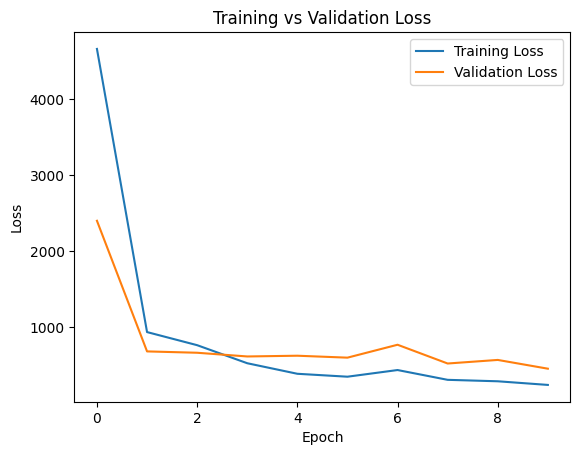

In [11]:
import matplotlib.pyplot as plt

# Assuming `train_loss_history` and `val_loss_history` were recorded during the training loop
plt.plot(range(num_epochs), train_loss_history, label="Training Loss")
plt.plot(range(num_epochs), val_loss_history, label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()


In [ ]:
# Save the trained model
torch.save(model.state_dict(), 'gaze_model.pth')
print("Model saved to gaze_model.pth")
